# Adult Income Census – Customer Segmentation

## 1. Project Goal
The goal is to group or categorise the customers based on similar features, so targeted marketing can be implemented to meet and address the needs of many individuals.

## 2. Project Dependencies and Libraries

If you are running the notebook in colab, please run the below cell.
If you are running the notebook in any other local editor, please use requirements.txt to install any external libraries and ignore to run the below cell

In [1]:
!pip install shap catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import shap
import umap
from catboost import CatBoostClassifier, Pool
from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.cluster import KMeans
from scipy import sparse
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

#3. Data Load and Overview

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
df = pd.read_csv('/content/sample_data/census-bureau.data', header = None)
columns = pd.read_csv('/content/sample_data/census-bureau.columns', header = None)

df.columns = columns[0].tolist()
print("Shape of the dataframe",df.shape)
df.head(5)

Shape of the dataframe (199523, 42)


age                 class of worker  detailed industry recode  \
0   73                 Not in universe                         0   
1   58  Self-employed-not incorporated                         4   
2   18                 Not in universe                         0   
3    9                 Not in universe                         0   
4   10                 Not in universe                         0   

   detailed occupation recode                   education  wage per hour  \
0                           0        High school graduate              0   
1                          34  Some college but no degree              0   
2                           0                  10th grade              0   
3                           0                    Children              0   
4                           0                    Children              0   

  enroll in edu inst last wk   marital stat          major industry code  \
0            Not in universe        Widowed  Not in universe or children   
1            Not in universe       Divorced                 Construction   
2                High school  Never married  Not in universe or children   
3            Not in universe  Never married  Not in universe or children   
4            Not in universe  Never married  Not in universe or children   

                 major occupation code  ... country of birth father  \
0                      Not in universe  ...           United-States   
1  Precision production craft & repair  ...           United-States   
2                      Not in universe  ...                 Vietnam   
3                      Not in universe  ...           United-States   
4                      Not in universe  ...           United-States   

  country of birth mother country of birth self  \
0           United-States         United-States   
1           United-States         United-States   
2                 Vietnam               Vietnam   
3           United-States         United-States   
4           United-States         United-States   

                           citizenship own business or self employed  \
0    Native- Born in the United States                             0   
1    Native- Born in the United States                             0   
2  Foreign born- Not a citizen of U S                              0   
3    Native- Born in the United States                             0   
4    Native- Born in the United States                             0   

  fill inc questionnaire for veteran's admin  veterans benefits  \
0                            Not in universe                  2   
1                            Not in universe                  2   
2                            Not in universe                  2   
3                            Not in universe                  0   
4                            Not in universe                  0   

   weeks worked in year  year     label  
0                     0    95  - 50000.  
1                    52    94  - 50000.  
2                     0    95  - 50000.  
3                     0    94  - 50000.  
4                     0    94  - 50000.  

[5 rows x 42 columns]

In [4]:
summary = []
for col in df.columns:
    summary.append({
        "column": col,
        "dtype": df[col].dtype,
        "unique_values": df[col].nunique(),
        "sample_values": df[col].unique()
    })

summary_df = pd.DataFrame(summary)
print(summary_df)

                                        column    dtype  unique_values  \
0                                          age    int64             91   
1                              class of worker   object              9   
2                     detailed industry recode    int64             52   
3                   detailed occupation recode    int64             47   
4                                    education   object             17   
5                                wage per hour    int64           1240   
6                   enroll in edu inst last wk   object              3   
7                                 marital stat   object              7   
8                          major industry code   object             24   
9                        major occupation code   object             15   
10                                        race   object              5   
11                             hispanic origin   object              9   
12                                    

## 3. Data Quality & Missing Values

In [5]:
# -------------------------------
# Identify columns with null values
# -------------------------------

# Columns that contain at least one null value
null_cols = df.columns[df.isnull().any()]
print("Columns with null values:", null_cols)

# Count of null values per column (only where count > 0)
null_counts = df.isnull().sum()
print("\nNumber of null values per column:", null_counts[null_counts > 0])

# -------------------------------
# Observation:  NULL values can be replaced with 'Do not know' value
# -------------------------------


# -------------------------------
# Handle ambiguous value '?'
# -------------------------------

mask = (df == '?').any(axis=1)
count_rows = mask.sum()
print("Count of rows with ? value ",count_rows)

mask = (df == '?') | (df.isnull())
cols_with_missing = df.columns[mask.any(axis=0)]
print("Columns with missing values:", cols_with_missing)

# -------------------------------
# Since more than 50% of the data contains "?", we cannot drop these rows.
# -------------------------------


df['hispanic origin'] = df['hispanic origin'].fillna('Do not know')
df['migration code-change in msa'] = (
    df['migration code-change in msa']
    .replace('?', 'Not identifiable')
)
df = df.replace('?', 'Unknown')


# -------------------------------
# Re-check missing values after cleaning
# -------------------------------


mask = (df == '?').any(axis=1) | df.isna().any(axis=1)
rows_with_missing_spch = df[mask]
print("rows with null values or ? after cleaning:", rows_with_missing_spch.shape)



Columns with null values: Index(['hispanic origin'], dtype='object')

Number of null values per column: hispanic origin    874
dtype: int64
Count of rows with ? value  104393
Columns with missing values: Index(['hispanic origin', 'state of previous residence',
       'migration code-change in msa', 'migration code-change in reg',
       'migration code-move within reg', 'migration prev res in sunbelt',
       'country of birth father', 'country of birth mother',
       'country of birth self'],
      dtype='object')
rows with null values or ? after cleaning: (0, 42)


## 4. Exploratory Data Analysis

Please refer to the EDA performed for classification notebook for more detail analysis.

In [6]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols.extend(['year','detailed occupation recode', 'detailed industry recode', 'veterans benefits','own business or self employed'])
numerical_int_cols = [
    'age',
    'wage per hour',
    'capital gains',
    'capital losses',
    'dividends from stocks',
    'num persons worked for employer',
    'weeks worked in year'
]


In [7]:
# ✅ CREATE FIGURE AND AXES
fig, axes = plt.subplots(
    nrows=4,
    ncols=2,
    figsize=(10, 20)
)

# Ensure axes is iterable
axes = axes.flatten()
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def format_y_axis(x, pos):
    if x >= 1_000_000:
        return f'{x/1_000_000:.1f}M'
    elif x >= 1_000:
        return f'{int(x/1_000)}K'
    else:
        return str(int(x))

# Flatten axes array for easy iteration if there's only one row
if len(numerical_int_cols) == 1:
    axes = [axes]

for i, col in enumerate(numerical_int_cols):
    ax = axes[i]
    # Plot weighted histogram
    ax.hist(df[col], bins=90, weights=df['weight'], edgecolor='black', alpha=0.7)
    ax.set_title(f'Weighted Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Weighted Count')
    ax.yaxis.set_major_formatter(FuncFormatter(format_y_axis))
    # Add grid for better readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)

for i in range(len(numerical_int_cols), len(axes)):
    fig.delaxes(axes[i]) # Remove the unused subplot



plt.tight_layout()
plt.show()

In [8]:
print("Total Population",df['weight'].sum())
## total population for a city : 347.245 million records
## total age = 0 no of records is 5.18 million
## all aged = 0 had work as Children correctly signifiyig
## 2 records have inconsistent value for 'veteran benefits'
## removing 7 records where children have their marital status as 'Married-civilian spouse present' which doesnot make sense

print(df.loc[df['age'] == 0]['weight'].count()) #2839
print(df.loc[df['age'] == 0]['weight'].sum()) # 5.18 million records
print(df.loc[df['age'] == 0]['education'].value_counts()) #observed only Children distinct value
print(df.loc[df['age'] == 0]['veterans benefits'].value_counts()) # 2 inconsistent records but choose to ignore
print(df.loc[df['age'] == 0]['full or part time employment stat'].value_counts()) # all records have Children value
print(df.loc[df['age'] == 0]['class of worker'].value_counts()) # Not in Universe indicative of not applicable to work
condition = (
    (df['age'] < 18) &
    (df['education'] == 'Children') &
    (df['marital stat'] == 'Married-civilian spouse present')
)
print("record_count",df.loc[(df['age'] < 18) & (df['education'] == 'Children') & (df['marital stat']=='Married-civilian spouse present')]['weight'].sum())

# Planning to remove : weighted 131514 record because it doesnot make sense for a child to be married.
# remove 7 records who are children and have marital status
df_filtered = df.loc[~condition].reset_index(drop=True)


## Applying log on columns that have left/right skewed distribution
skewed_cols = [ 'wage per hour', 'capital gains', 'capital losses', 'dividends from stocks','weeks worked in year']
for col in skewed_cols:
    df_filtered[col] = np.log1p(df_filtered[col])


Total Population 347245892.46999997
2839
5187670.5600000005
education
Children    2839
Name: count, dtype: int64
veterans benefits
0    2837
2       2
Name: count, dtype: int64
full or part time employment stat
Children or Armed Forces    2839
Name: count, dtype: int64
class of worker
Not in universe    2839
Name: count, dtype: int64
record_count 13917.08


## 5. Feature Engineering & Encoding

In [10]:
## grouping certain distinct values of Education column under one commnon bin to reduce the feature space of this specific column
df_filtered['education'].unique()

df_filtered['education'].replace(['7th and 8th grade', '5th or 6th grade' ,'1st 2nd 3rd or 4th grade', 'Less than 1st grade', '9th grade', '10th grade'], "Kindergarden to 10th grade", inplace = True)
df_filtered['education'].unique()


array(['High school graduate', 'Some college but no degree',
       'Kindergarden to 10th grade', 'Children',
       'Bachelors degree(BA AB BS)',
       'Masters degree(MA MS MEng MEd MSW MBA)',
       'Associates degree-academic program', '12th grade no diploma',
       'Associates degree-occup /vocational',
       'Prof school degree (MD DDS DVM LLB JD)', '11th grade',
       'Doctorate degree(PhD EdD)'], dtype=object)

In [11]:
df_filtered['detailed household and family stat'].unique()
import re

def parse_household_rel(s):
    # Relation
    if "Householder" in s:
        relation = "Householder"
    elif "Spouse" in s:
        relation = "Spouse"
    elif "Child" in s:
        relation = "Child"
    elif "Grandchild" in s:
        relation = "Grandchild"
    elif "Other Rel" in s:
        relation = "Other_Rel"
    elif "RP" in s:
        relation = "RP_unrelated"
    elif "Secondary individual" in s:
        relation = "Secondary"
    elif "Nonfamily householder" in s:
        relation = "Nonfamily_householder"
    elif "In group quarters" in s:
        relation = "In_group_quarters"
    else:
        relation = "Other"

    # Age group
    if "<18" in s:
        age_group = "<18"
    elif "18+" in s:
        age_group = "18+"
    else:
        age_group = "Unknown"

    # Marital status
    if "never marr" in s or "never married" in s:
        marital = "Never_married"
    elif "ever marr" in s:
        marital = "Ever_married"
    elif "spouse" in s:
        marital = "Spouse"
    else:
        marital = "Unknown"

    # Subfamily membership
    if "in subfamily" in s:
        subfamily = "In_subfamily"
    elif "not in subfamily" in s:
        subfamily = "Not_in_subfamily"
    elif "child of subfamily RP" in s:
        subfamily = "Child_of_subfamily_RP"
    else:
        subfamily = "Unknown"

    return pd.Series([relation, age_group, marital, subfamily])

df_filtered[["relation", "age_group", "marriage_status", "subfamily"]] = df_filtered["detailed household and family stat"].apply(parse_household_rel)


In [12]:
## I have checked whether the newly created age_group and marriage_status columns exactly match
## existing age and marital stat columns
res1 = []
res2 = []
for index, row in df_filtered.iterrows():
  if row['age_group'] == '18+' and row['age']<18:
    res1.append(index)
  if row['age_group'] == '<18' and row['age']>=18:
    res2.append(index)

print("RESULT_age", res1, res2)
res1 = []
res2 = []
for index, row in df_filtered.iterrows():
  if row['marriage_status'] in ['Ever_married', 'Spouse'] and row['marital stat'] not in ['Married-civilian spouse present', 'Separated',
       'Married-spouse absent', 'Married-A F spouse present', 'Widowed', 'Divorced']:
    res1.append(index)
  if row['marriage_status'] == 'Never_married' and row['marital stat']!='Never married':
    res2.append(index)

print("RESULT_marriage_status", res1, res2)

RESULT_age [] []
RESULT_marriage_status [] []


In [13]:
df_filtered['detailed household summary in household'].unique()

# After observing that 'detailed household summary in household' is a simple version of the column
# 'detailed household and family stat' and using the incremental model approach finding that the detailed
# version added info doesot lead to prediction significance.
# I chose to drop 'detailed household and family stat' column as seen below




array(['Other relative of householder', 'Householder',
       'Child 18 or older', 'Child under 18 never married',
       'Spouse of householder', 'Nonrelative of householder',
       'Group Quarters- Secondary individual',
       'Child under 18 ever married'], dtype=object)

In [14]:
y = df_filtered['label']
Cg = df_filtered[['detailed household summary in household']]
Cd = df_filtered[['detailed household and family stat']]

pipe_1 = Pipeline([
    ('enc', OneHotEncoder(handle_unknown='ignore')),
    ('clf', LogisticRegression(max_iter=1000))
])

pipe_1.fit(Cg, y, clf__sample_weight=df_filtered['weight'])
pred_1 = pipe_1.predict_proba(Cg)[:,1]
auc_1 = roc_auc_score(y, pred_1, sample_weight=df_filtered['weight'])

X_full = pd.concat([Cg, Cd], axis=1)

pipe_2 = Pipeline([
    ('enc', OneHotEncoder(handle_unknown='ignore')),
    ('clf', LogisticRegression(max_iter=1000))
])

pipe_2.fit(X_full, y, clf__sample_weight=df_filtered['weight'])
pred_2 = pipe_2.predict_proba(X_full)[:,1]
auc_2 = roc_auc_score(y, pred_2, sample_weight=df_filtered['weight'])

print("AUC (Cg only):", auc_1)
print("AUC (Cg + Cd):", auc_2)
print("ΔAUC:", auc_2 - auc_1)

df_filtered.drop(columns=['detailed household and family stat'], inplace=True)



AUC (Cg only): 0.7573354213132386
AUC (Cg + Cd): 0.7756435235178194
ΔAUC: 0.01830810220458079


In [15]:
df_filtered.drop(columns=["relation", "age_group", "marriage_status", "subfamily"], inplace=True)

In [16]:
combinations = df_filtered[['migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg']].drop_duplicates()
print(combinations.shape[0])

# Though the above 3 columns have heirachial relation, I chose one hot encoding for each of the columns
# instead of performing one hot encoding for 73 columns
# I chose to have less features over the loss of information.

state_combi = df_filtered[['region of previous residence', 'state of previous residence']].drop_duplicates()
print(state_combi.shape[0])

# Create hierarchical interaction column
df_filtered['region_state_previous_residence'] = df_filtered['region of previous residence'] + "_" + df_filtered['state of previous residence']
df_filtered.drop(columns = ['region of previous residence','state of previous residence'], inplace=True)

# perform one hot encoding for thse columns


#decided to follow this approach with regards to country
#option 1: one hot encoding on 3 coluntry columns and apply logistic regression
#option 2: group c1, c2 mother and father country column values to same, different,
#unknown and perform one hot encoding with myself country and newly created column
#Before I planned to consider the above optiion, need to the check the proportion
#so the samples for rare countries, since we have around 42 countries with less than 1% of the records.
# Its better to replace them with other and proceed.

birth_combi = df_filtered[['country of birth father', 'country of birth mother', 'country of birth self']].drop_duplicates()
print(birth_combi)
birth_combi = df_filtered[['country of birth father', 'country of birth mother']].drop_duplicates()
print(birth_combi)

73
53
       country of birth father country of birth mother country of birth self
0                United-States           United-States         United-States
2                      Vietnam                 Vietnam               Vietnam
5                  Philippines           United-States         United-States
11                     Unknown                 Unknown               Unknown
13                    Columbia                Columbia              Columbia
...                        ...                     ...                   ...
197815                 England                  Greece                Canada
198302                    Cuba                  Poland                  Cuba
198413                Scotland                 Unknown         United-States
198590              Yugoslavia                   Italy         United-States
199467                 Jamaica                    Cuba               Jamaica

[1344 rows x 3 columns]
       country of birth father country of bir

In [17]:
print('Weighted proportions for country of birth father:')
weighted_proportions_father = df_filtered.groupby('country of birth father')['weight'].sum() / df_filtered['weight'].sum()
display(weighted_proportions_father.sort_values(ascending=False).head(10))

print('\nWeighted proportions for country of birth mother:')
weighted_proportions_mother = df_filtered.groupby('country of birth mother')['weight'].sum() / df_filtered['weight'].sum()
display(weighted_proportions_mother.sort_values(ascending=False).head(10))

print('\nWeighted proportions for country of birth self:')
weighted_proportions_self = df_filtered.groupby('country of birth self')['weight'].sum() / df_filtered['weight'].sum()
display(weighted_proportions_self.sort_values(ascending=False).head(10))

Weighted proportions for country of birth father:


country of birth father
United-States    0.821003
Mexico           0.043860
Unknown          0.032202
Italy            0.010830
Puerto-Rico      0.008705
Germany          0.006691
Poland           0.006170
Canada           0.006068
Philippines      0.005311
Cuba             0.004301
Name: weight, dtype: float64


Weighted proportions for country of birth mother:


country of birth mother
United-States    0.826571
Mexico           0.042857
Unknown          0.029378
Italy            0.008882
Puerto-Rico      0.007992
Germany          0.007070
Canada           0.006534
Philippines      0.005808
Poland           0.005580
El-Salvador      0.004801
Name: weight, dtype: float64


Weighted proportions for country of birth self:


country of birth self
United-States    0.899618
Mexico           0.025575
Unknown          0.016495
Puerto-Rico      0.004493
Germany          0.004442
Philippines      0.003988
Canada           0.003406
Cuba             0.003149
El-Salvador      0.003006
England          0.002296
Name: weight, dtype: float64

In [18]:
weighted_counts = df_filtered.groupby('country of birth father')['weight'].sum()
total_weight = weighted_counts.sum()
weighted_freq = weighted_counts / total_weight

# Define threshold for rare countries (e.g., <1% of total weight)
rare_threshold = 0.01
rare_countries = weighted_freq[weighted_freq > rare_threshold].index
print(len(rare_countries), rare_countries)

weighted_counts = df_filtered.groupby('country of birth mother')['weight'].sum()
total_weight = weighted_counts.sum()
weighted_freq = weighted_counts / total_weight

# Define threshold for rare countries (e.g., <1% of total weight)
rare_threshold = 0.01
rare_countries = weighted_freq[weighted_freq < rare_threshold].index
len(rare_countries)

weighted_counts = df_filtered.groupby('country of birth self')['weight'].sum()
total_weight = weighted_counts.sum()
weighted_freq = weighted_counts / total_weight

# Define threshold for rare countries (e.g., <1% of total weight)
rare_threshold = 0.01
rare_countries = weighted_freq[weighted_freq < rare_threshold].index
len(rare_countries)
rare_countries.tolist().append('Unknown')

# Replace rare countries with 'Other'
columns_with_rare = ['country of birth self','country of birth mother', 'country of birth father']

df_filtered[columns_with_rare] = df_filtered[columns_with_rare].replace(rare_countries, 'Other')
df_filtered['country of birth father'].value_counts()

4 Index(['Italy', 'Mexico', 'United-States', 'Unknown'], dtype='object', name='country of birth father')


country of birth father
United-States    159159
Other             23638
Mexico            10006
Unknown            6713
Name: count, dtype: int64

In [19]:

# Create a DataFrame with features AND weight for transformation
# 'weight' must be in this DataFrame so it's processed and eventually split
X_features_df = df_filtered.drop(columns=['label'])

# --- Define feature types for ColumnTransformer ---
# Ensure numerical_int_cols is based on the globally defined list
# Filter out any numerical_int_cols that might have been dropped from X_features_df
numerical_features_for_ct = [col for col in numerical_int_cols if col in X_features_df.columns]

# IMPORTANT: Add 'weight' to numerical_features_for_ct as it needs to be passed through
if 'weight' in X_features_df.columns and 'weight' not in numerical_features_for_ct:
    numerical_features_for_ct.append('weight')

ordinal_cols = ['education']

# Get all potential nominal columns first
all_potential_nominal_cols = [
    col for col in X_features_df.columns.tolist()
    if col not in numerical_features_for_ct + ordinal_cols
]

# Filter out nominal columns that have only one unique value.
# These columns will produce 0 features with OneHotEncoder(drop='first'),
# but get_feature_names_out() might still generate one name, causing a mismatch.
# This check is crucial to align the number of features with generated names.
nominal_cols = [
    col for col in all_potential_nominal_cols
    if X_features_df[col].nunique() > 1
]

# Ordinal mapping (already defined)
education_order = ['Children', 'Kindergarden to 10th grade', '11th grade', '12th grade no diploma', 'High school graduate', 'Some college but no degree', 'Associates degree-occup /vocational', 'Associates degree-academic program', 'Bachelors degree(BA AB BS)', 'Masters degree(MA MS MEng MEd MSW MBA)', 'Prof school degree (MD DDS DVM LLB JD)', 'Doctorate degree(PhD EdD)']

# ColumnTransformer setup
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), nominal_cols),
        ('ordinal', OrdinalEncoder(categories=[education_order], handle_unknown='use_encoded_value', unknown_value=-1), ordinal_cols),
        ('numerical', 'passthrough', numerical_features_for_ct) # 'weight' is now part of this
    ],
    remainder='drop' # Drop any other columns not explicitly listed
)

# Transform the features DataFrame (which now includes 'weight')
X_processed = preprocessor.fit_transform(X_features_df)

# Generate column names for the processed numpy array
import pandas as pd
processed_feature_names = preprocessor.get_feature_names_out()
df_encoded = pd.DataFrame(X_processed, columns=processed_feature_names)

df_encoded.shape

# Store the prefixed numerical column names for scaling (EXCLUDING weight)
# The scaler will be applied to these columns.
# We need to make sure 'numerical__weight' is NOT in this list for scaling.
global numerical_cols_for_scaling
numerical_cols_for_scaling = [f'numerical__{col}' for col in numerical_int_cols if col in X_features_df.columns]


In [20]:
print(df_filtered.shape)
print(df_encoded.shape)
scaler = StandardScaler()
# Use the globally defined numerical_cols_for_scaling (which explicitly excludes 'weight')
df_encoded[numerical_cols_for_scaling] = scaler.fit_transform(df_encoded[numerical_cols_for_scaling])
val = 0
for col in df_filtered.columns:
  if col not in numerical_features_for_ct and col!='label' and col!='education':
    size = len(df_filtered[col].unique()) - 1
    val = val + size
print(val+1 + len(numerical_features_for_ct))



(199516, 40)
(199516, 304)
304


## 6. Unsupervised Models

1. weighted k - means
2. weighted k - prototypes
3. DBScan

In [ ]:
# sil_scores = []
# weights = df_encoded['numerical__weight']
# X_scaled = df_encoded.drop(columns=['numerical__weight'])


# for k in range(2, 10):
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     labels = kmeans.fit_predict(X_scaled, sample_weight=weights)
#     sil = silhouette_score(X_scaled, labels)
#     sil_scores.append(sil)

# pd.DataFrame({
#     "k": range(2, 8),
#     "silhouette_score": sil_scores
# })

KeyboardInterrupt: 

In [21]:
weights = df_encoded['numerical__weight']
X_scaled = df_encoded.drop(columns=['numerical__weight'])
X_sparse = sparse.csr_matrix(X_scaled)

## 6 A) Weighted K - Means

In [22]:
from sklearn.metrics import davies_bouldin_score

db_scores = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled, sample_weight=weights)
    db_scores.append(davies_bouldin_score(X_scaled, labels))

pd.DataFrame({
    "k": range(2, 10),
    "davies_bouldin": db_scores
})


k  davies_bouldin
0  2        1.364124
1  3        1.866068
2  4        2.025235
3  5        2.191124
4  6        2.201561
5  7        2.163918
6  8        2.077594
7  9        2.034057

In [23]:
k =  5 # based on DBI index

kmeans = KMeans(
    n_clusters=k,
    random_state=42,
    n_init=20
)

df_encoded["cluster"] = kmeans.fit_predict(
    X_scaled,
    sample_weight=weights,
)


#db_index = davies_bouldin_score(X_scaled, df_encoded["cluster"])
#print(f"Davies–Bouldin Index: {db_index:.3f}")

In [24]:
cluster_population = (
    df_encoded.groupby("cluster")["numerical__weight"]
    .sum()
    .reset_index(name="population_weight")
)

cluster_population["population_pct"] = (
    cluster_population["population_weight"]
    / cluster_population["population_weight"].sum()
) * 100

cluster_population

cluster  population_weight  population_pct
0        0       8.337452e+07       24.011189
1        1       1.156175e+08       33.296900
2        2       8.311642e+07       23.936857
3        3       5.808680e+07       16.728530
4        4       7.036740e+06        2.026524

In [25]:
int_col = []
obj_col = []
for col in df_encoded.columns:
    if col.startswith("onehot__") or col.startswith("ordinal__"):
        obj_col.append(col)
    elif col.startswith("numerical__"):
      if col != "numerical__weight":
        int_col.append(col)
print(len(int_col), len(obj_col))
print(df_encoded.shape)

7 296
(199516, 305)


In [26]:
# -------------------------
# Function to summarize categorical variables
# -------------------------
def summarize_categorical(df, cluster_col, cat_cols, weight_col, top_n=2):
    summary = {}
    for cluster in sorted(df[cluster_col].unique()):
        cluster_data = df[df[cluster_col]==cluster]
        cluster_summary = {}
        for col in cat_cols:
            weighted_counts = cluster_data.groupby(col)[weight_col].sum()
            top_categories = (weighted_counts / weighted_counts.sum()).sort_values(ascending=False).head(top_n)
            cluster_summary[col] = top_categories.to_dict()
        summary[cluster] = cluster_summary
    return summary

# -------------------------
# Weighted numerical summary
# -------------------------
num_summary = df_encoded.groupby("cluster").apply(
    lambda x: pd.Series({
        col: np.average(x[col], weights=x["numerical__weight"]) for col in int_col
    })
).round(2)

# -------------------------
# Weighted categorical summary
# -------------------------
cat_summary = summarize_categorical(df_encoded, "cluster", obj_col, "numerical__weight")

# -------------------------
# Population size per cluster
# -------------------------
cluster_population = (
    df_encoded.groupby("cluster")["numerical__weight"].sum().reset_index(name="population_weight")
)
cluster_population["population_pct"] = 100 * cluster_population["population_weight"] / cluster_population["population_weight"].sum()

# -------------------------
# Combine summaries and print marketing insights
# -------------------------
for cluster in range(k):
    print(f"\n===== Cluster {cluster} =====")
    print(f"Population: {cluster_population.loc[cluster_population['cluster']==cluster, 'population_pct'].values[0]:.2f}%")

    print("\nNumerical features:")
    print(num_summary.loc[cluster])

    print("\nTop categorical features:")
    for col, values in cat_summary[cluster].items():
        print(f"{col}: {values}")



/tmp/ipython-input-3465936553.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  num_summary = df_encoded.groupby("cluster").apply(



===== Cluster 0 =====
Population: 24.01%

Numerical features:
numerical__age                                0.36
numerical__wage per hour                      0.18
numerical__capital gains                      0.03
numerical__capital losses                    -0.14
numerical__dividends from stocks             -0.02
numerical__num persons worked for employer    0.37
numerical__weeks worked in year               0.45
Name: 0, dtype: float64

Top categorical features:
onehot__class of worker_Local government: {0.0: 0.9591687085987431, 1.0: 0.04083129140125693}
onehot__class of worker_Never worked: {0.0: 0.99891537984592, 1.0: 0.0010846201540800002}
onehot__class of worker_Not in universe: {0.0: 0.7120400748272403, 1.0: 0.2879599251727598}
onehot__class of worker_Private: {1.0: 0.5554406334280367, 0.0: 0.4445593665719632}
onehot__class of worker_Self-employed-incorporated: {0.0: 0.9831061218955652, 1.0: 0.016893878104434695}
onehot__class of worker_Self-employed-not incorporated: {0.0: 0.

## 6 B) K - Prototypes

In [27]:
categorical_cols = df_filtered.select_dtypes(include=['object']).columns.tolist()
categorical_cols.extend(['year','detailed occupation recode', 'detailed industry recode', 'veterans benefits','own business or self employed'])
numerical_int_cols = [
    'age',
    'wage per hour',
    'capital gains',
    'capital losses',
    'dividends from stocks',
    'num persons worked for employer',
    'weeks worked in year',
    'weight'
]

In [28]:
weights = df_filtered['weight'].values
df_final = df_filtered.drop(columns=['weight'])
numerical_int_cols.remove('weight')
X_num = df_final[numerical_int_cols].values
X_cat = df_filtered[categorical_cols].values
# Scale numeric features
scaler = StandardScaler()
X_num = scaler.fit_transform(X_num)

# Integer-encode categorical features
cat_encoder = OrdinalEncoder(dtype=np.int32, handle_unknown="use_encoded_value", unknown_value=-1)
X_cat = cat_encoder.fit_transform(X_cat).astype(np.int32)


In [29]:
from scipy.spatial.distance import cdist

def weighted_k_prototypes(
    X_num,
    X_cat,
    weights,
    n_clusters=5,
    gamma=1.0,
    max_iter=20,
    random_state=42,
    tol=1e-4
):
    """
    Fast weighted k-prototypes with integer-encoded categorical variables
    """

    rng = np.random.default_rng(random_state)
    n_samples, p = X_num.shape
    _, q = X_cat.shape

    # ---- Initialization ----
    init_idx = rng.choice(n_samples, size=n_clusters, replace=False)
    centroids_num = X_num[init_idx].copy()
    centroids_cat = X_cat[init_idx].copy()

    labels = np.full(n_samples, -1, dtype=np.int32)

    for it in range(max_iter):
        prev_labels = labels.copy()

        # ---- Distance computation ----
        # Numeric distance (Euclidean)
        dist_num = cdist(X_num, centroids_num, metric="euclidean")

        # Categorical distance (vectorized mismatch counting)
        dist_cat = np.zeros((n_samples, n_clusters), dtype=np.float32)
        for k in range(n_clusters):
            dist_cat[:, k] = np.sum(X_cat != centroids_cat[k], axis=1)

        # Total distance
        dist_total = dist_num + gamma * dist_cat

        # ---- Assignment ----
        labels = np.argmin(dist_total, axis=1)

        # ---- Convergence check ----
        if np.all(labels == prev_labels):
            break

        # ---- Update centroids ----
        for k in range(n_clusters):
            mask = labels == k
            if not np.any(mask):
                continue

            w = weights[mask]
            w_sum = w.sum()

            # Numeric centroid (weighted mean)
            centroids_num[k] = np.average(X_num[mask], axis=0, weights=w)

            # Categorical centroid (weighted mode)
            for j in range(q):
                vals = X_cat[mask, j]
                unique_vals, inv = np.unique(vals, return_inverse=True)
                weighted_counts = np.zeros(len(unique_vals))
                np.add.at(weighted_counts, inv, w)
                centroids_cat[k, j] = unique_vals[np.argmax(weighted_counts)]

    return labels, centroids_num, centroids_cat


In [30]:
labels, centroids_num, centroids_cat = weighted_k_prototypes(
    X_num,
    X_cat,
    weights,
    n_clusters=5,
    gamma=0.5,   # tune this
    max_iter=15
)

df_filtered["cluster"] = labels


In [31]:
df_filtered["cluster"].value_counts()

cluster
2    62485
3    49481
0    46026
4    37689
1     3835
Name: count, dtype: int64

## 10. Visualisation of Clustered Segements

In [32]:
# -----------------------------
# Step 0: Prepare Data
# -----------------------------
# df_encoded contains your features, cluster labels, and weight
# Columns: all features + 'cluster' + 'numerical__weight'

features = df_encoded.drop(columns=['cluster', 'numerical__weight'])
weights = df_encoded['numerical__weight'].values
cluster_labels = df_encoded['cluster'].values

# -----------------------------
# Step 1: Sample for Visualization
# -----------------------------
# Sample 20k points weighted by population to speed up UMAP
sample_df = df_encoded.sample(20000, weights=df_encoded['numerical__weight'], random_state=42)
X_sample = sample_df.drop(columns=['cluster', 'numerical__weight'])
weights_sample = sample_df['numerical__weight'].values
clusters_sample = sample_df['cluster'].values

# -----------------------------
# Step 2: PCA Dimensionality Reduction (optional but faster)
# -----------------------------
pca = PCA(n_components=50, random_state=42)  # reduce to 50 dims for speed
X_pca = pca.fit_transform(X_sample)

# -----------------------------
# Step 3: UMAP Projection to 2D
# -----------------------------
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_pca)

sample_df['umap1'] = X_umap[:,0]
sample_df['umap2'] = X_umap[:,1]

# -----------------------------
# Step 4: Scatter Plot
# -----------------------------
plt.figure(figsize=(10,7))
sns.scatterplot(
    data=sample_df,
    x='umap1',
    y='umap2',
    hue='cluster',                 # cluster color
    size='numerical__weight',      # population weight
    sizes=(10,200),
    palette='tab10',
    alpha=0.7
)
plt.title("Weighted Cluster Visualization (PCA + UMAP Projection)")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [33]:
# -----------------------------
# Step 0: Prepare Data
# -----------------------------
# df_encoded contains your features, cluster labels, and weight
# Columns: all features + 'cluster' + 'numerical__weight'

features = df_encoded.drop(columns=['cluster', 'numerical__weight'])
weights = df_encoded['numerical__weight'].values
cluster_labels = df_encoded['cluster'].values

# -----------------------------
# Step 1: Sample for Visualization
# -----------------------------
# Sample 20k points weighted by population to speed up UMAP
sample_df = df_encoded.sample(20000, weights=df_encoded['numerical__weight'], random_state=42)
sample_indices = sample_df.index



X_sample = sample_df.drop(columns=['cluster', 'numerical__weight'])
weights_sample = sample_df['numerical__weight'].values
clusters_sample = df_filtered['cluster'].values

# -----------------------------
# Step 2: PCA Dimensionality Reduction (optional but faster)
# -----------------------------
pca = PCA(n_components=50, random_state=42)  # reduce to 50 dims for speed
X_pca = pca.fit_transform(X_sample)

# -----------------------------
# Step 3: UMAP Projection to 2D
# -----------------------------
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_pca)

sample_df['umap1'] = X_umap[:,0]
sample_df['umap2'] = X_umap[:,1]
sample_df['cluster_k_prototypes'] = df_filtered.loc[sample_indices]['cluster'].values

# -----------------------------
# Step 4: Scatter Plot
# -----------------------------
plt.figure(figsize=(10,7))
sns.scatterplot(
    data=sample_df,
    x='umap1',
    y='umap2',
    hue='cluster_k_prototypes',                 # cluster color
    size='numerical__weight',      # population weight
    sizes=(10,200),
    palette='tab10',
    alpha=0.7
)
plt.title("Weighted Cluster Visualization (PCA + UMAP Projection)")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [34]:
n_clusters = centroids_num.shape[0]
n_numeric = X_num.shape[1]
n_categorical = X_cat.shape[1]


# Store contributions for each cluster
cluster_feature_contrib = [ [] for _ in range(n_clusters) ]

for i in range(X_num.shape[0]):
    cluster_idx = cluster_labels[i]

    # Numeric contribution
    num_diff = (X_num[i] - centroids_num[cluster_idx])**2

    # Categorical contribution
    cat_diff = (X_cat[i] != centroids_cat[cluster_idx]).astype(int)

    # Combine numeric + categorical
    feature_contribution = np.concatenate([num_diff, cat_diff])

    cluster_feature_contrib[cluster_idx].append(feature_contribution)

# Convert lists to arrays for easier aggregation
for k in range(n_clusters):
    cluster_feature_contrib[k] = np.array(cluster_feature_contrib[k])

#cluster_avg_numeric[k] → mean of numeric features for cluster k
#cluster_avg_categorical[k] → most frequent value (mode) for categorical features



In [35]:
# Compute average contribution of each feature within a cluster
cluster_avg_contrib = []
for k in range(n_clusters):
    # Mean across all records in the cluster
    avg_contrib = cluster_feature_contrib[k].mean(axis=0)
    cluster_avg_contrib.append(avg_contrib)


In [36]:
top_features_per_cluster = []
for k in range(n_clusters):
    # Get indices of top 10 contributing features
    top_idx = np.argsort(cluster_avg_contrib[k])[-20:]
    top_features_per_cluster.append(top_idx)

# Now top_features_per_cluster[k] gives top 10 features for cluster k
print(top_features_per_cluster)


features = numerical_int_cols + categorical_cols
for each in top_features_per_cluster:
    print(f"Cluster {each}:")
    print([features[i] for i in each])

[array([20, 19, 15,  0, 11, 36, 12,  4, 35, 18, 22, 23, 21, 25, 24, 34,  6,
        2,  5,  1]), array([24, 21, 25, 22, 23, 34, 15,  4, 37, 26, 20, 10, 19,  7, 12,  8,  5,
        0,  6,  3]), array([36,  7, 10, 19,  4, 20, 26, 21, 25, 24, 22, 23,  8, 37, 34,  2,  1,
        5,  0,  6]), array([ 0, 21, 23, 24, 22, 25, 34,  7, 15, 18,  6, 35, 12, 36, 11,  5,  8,
        1,  4,  2]), array([34, 24, 23, 25, 21, 22, 15,  8,  0,  7, 12, 35, 11, 36, 19,  1,  4,
        5,  6,  3])]
Cluster [20 19 15  0 11 36 12  4 35 18 22 23 21 25 24 34  6  2  5  1]:
['detailed household summary in household', 'tax filer stat', 'sex', 'age', 'major industry code', 'detailed industry recode', 'major occupation code', 'dividends from stocks', 'detailed occupation recode', 'full or part time employment stat', 'migration code-change in reg', 'migration code-move within reg', 'migration code-change in msa', 'migration prev res in sunbelt', 'live in this house 1 year ago', 'year', 'weeks worked in year', 'capital

In [37]:
# df_encoded: your dataset with features + 'cluster' + 'numerical__weight'

# Features
X = df_encoded.drop(columns=['cluster', 'numerical__weight'])
y = df_encoded['cluster']
weights = df_encoded['numerical__weight']

#Optional: sample for faster SHAP computation if needed
sample_size = 20000
idx = np.random.choice(len(X), sample_size, replace=False)
X, y, weights = X.iloc[idx], y.iloc[idx], weights.iloc[idx]


In [38]:
# Train Random Forest with sample weights
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Prepare X, y, weights for this specific RF model and its SHAP values
X_for_rf_shap = df_encoded.drop(columns=['cluster', 'numerical__weight'])
y_for_rf_shap = df_encoded['cluster']
weights_for_rf_shap = df_encoded['numerical__weight']

# Sample for faster SHAP computation if needed
sample_size = 20000
idx_for_rf_shap = np.random.choice(len(X_for_rf_shap), sample_size, replace=False)
X_for_rf_shap = X_for_rf_shap.iloc[idx_for_rf_shap]
y_for_rf_shap = y_for_rf_shap.iloc[idx_for_rf_shap]
weights_for_rf_shap = weights_for_rf_shap.iloc[idx_for_rf_shap]

rf.fit(X_for_rf_shap, y_for_rf_shap, sample_weight=weights_for_rf_shap)

# Compute SHAP values (TreeSHAP)
explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = explainer_rf.shap_values(X_for_rf_shap)  # List of arrays: one per cluster

# shap_values_rf[i] shape = (n_samples, n_features) for cluster i

In [39]:
X = df_encoded.drop(columns=['cluster', 'numerical__weight'])
y = df_filtered['cluster']
weights = df_encoded['numerical__weight']

#Optional: sample for faster SHAP computation if needed
sample_size = 20000
idx = np.random.choice(len(X), sample_size, replace=False)
X, y, weights = X.iloc[idx], y.iloc[idx], weights.iloc[idx]
rf_k_proto = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_k_proto.fit(X, y, sample_weight=weights)

# Compute SHAP values (TreeSHAP)
explainer_rf_k_proto = shap.TreeExplainer(rf_k_proto)
shap_values_rf_k_proto = explainer_rf.shap_values(X)

In [40]:
# Function to get top contributing features per cluster
def top_shap_features(shap_values_list, X, top_n=10):
    """
    shap_values_list: list of arrays, each (n_samples, n_features) for each cluster
    X: feature dataframe
    """
    cluster_features = {}
    for i, cluster_vals in enumerate(shap_values_list):
        # Mean absolute SHAP per feature
        mean_abs_shap = np.abs(cluster_vals).mean(axis=0)
        top_idx = np.argsort(mean_abs_shap)[-top_n:][::-1]
        cluster_features[f'Cluster {i}'] = X.columns[top_idx].tolist()
    return cluster_features

# Random Forest top features
top_features_rf = top_shap_features(shap_values_rf, X, top_n=10)
print("Random Forest Top Features per Cluster:")
for k,v in top_features_rf.items():
    print(k, ":", v)


Random Forest Top Features per Cluster:
Cluster 0 : ['onehot__class of worker_Local government', 'onehot__class of worker_Not in universe', 'onehot__class of worker_Private', 'onehot__class of worker_Self-employed-incorporated', 'onehot__class of worker_Never worked']
Cluster 1 : ['onehot__class of worker_Never worked', 'onehot__class of worker_Not in universe', 'onehot__class of worker_Self-employed-incorporated', 'onehot__class of worker_Local government', 'onehot__class of worker_Private']
Cluster 2 : ['onehot__class of worker_Never worked', 'onehot__class of worker_Local government', 'onehot__class of worker_Not in universe', 'onehot__class of worker_Self-employed-incorporated', 'onehot__class of worker_Private']
Cluster 3 : ['onehot__class of worker_Private', 'onehot__class of worker_Local government', 'onehot__class of worker_Not in universe', 'onehot__class of worker_Self-employed-incorporated', 'onehot__class of worker_Never worked']
Cluster 4 : ['onehot__class of worker_Local 

In [42]:
X_for_rf_shap.shape

(20000, 303)

In [41]:
shap_values_rf.shape

(20000, 303, 5)

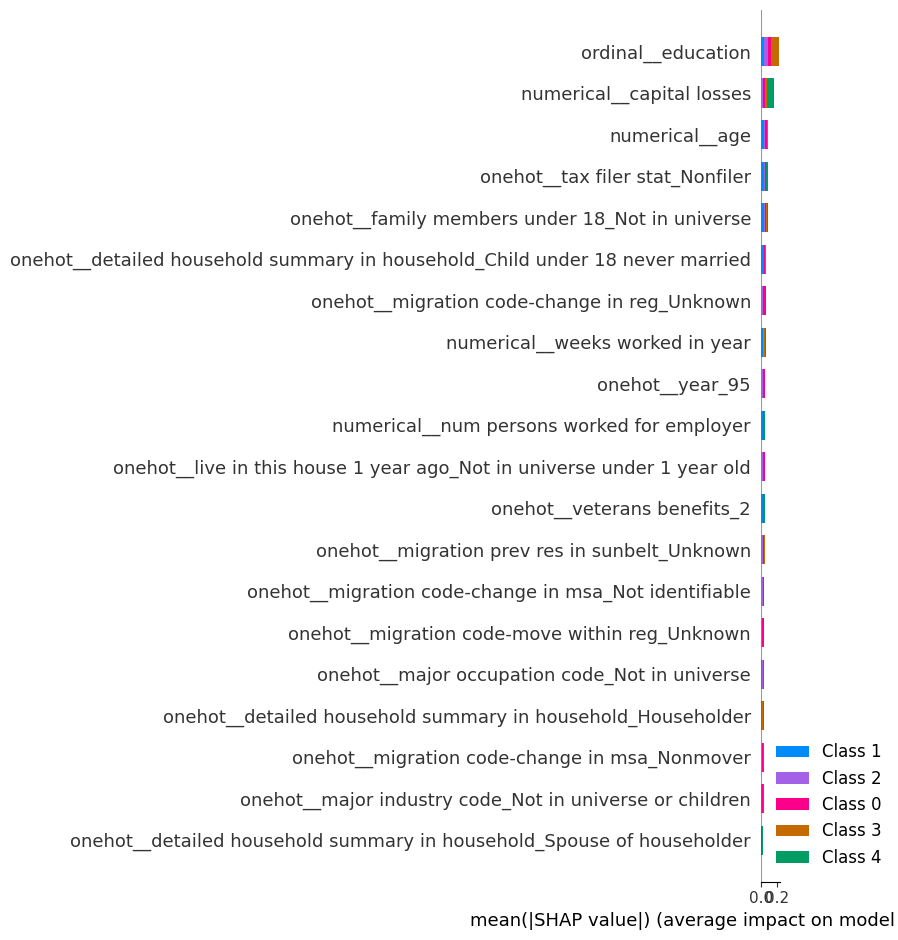

In [45]:
# Global summary plot (all clusters combined)
# This assumes X_for_rf_shap was created in FxoD0T4ppXti
shap.summary_plot(shap_values_rf, X_for_rf_shap, plot_type="bar")

# Individual record explanation
record_idx = 0
# This assumes X_for_rf_shap was created in FxoD0T4ppXti
shap.force_plot(explainer_rf.expected_value[0], shap_values_rf[record_idx, :, 0], X_for_rf_shap.iloc[record_idx])

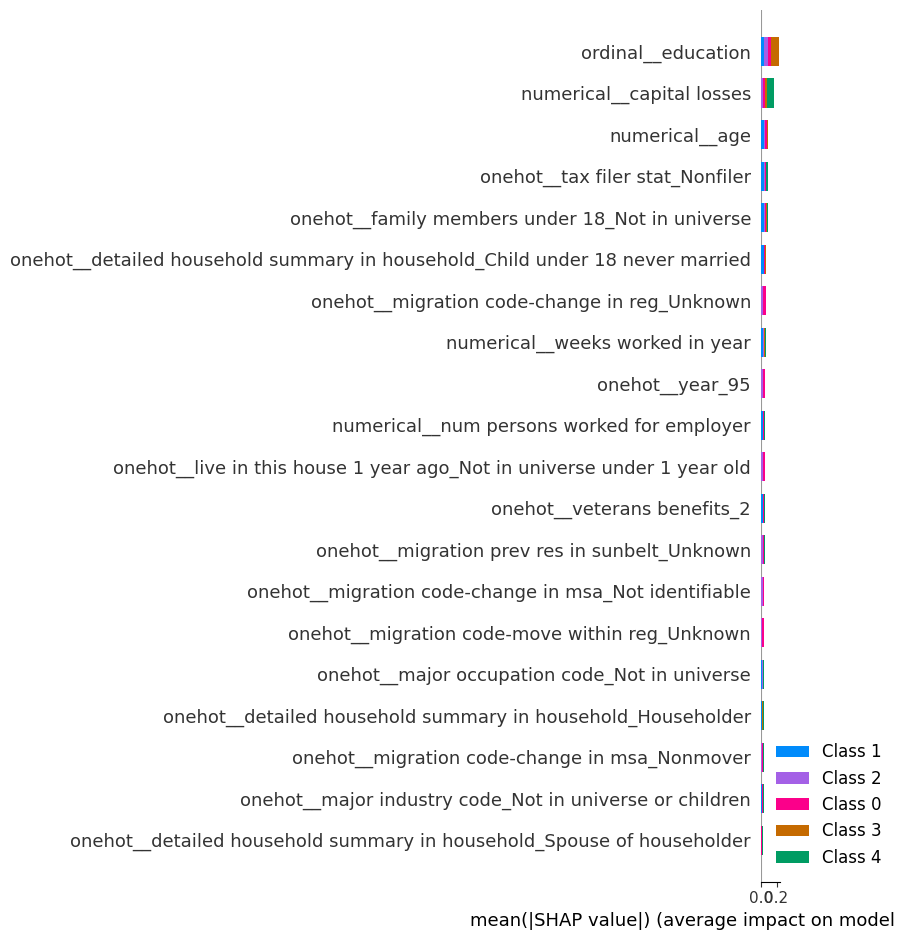

In [47]:
# Global summary plot (all clusters combined)
shap.summary_plot(shap_values_rf_k_proto, X, plot_type="bar")

# Individual record explanation
record_idx = 0
shap.force_plot(explainer_rf_k_proto.expected_value[0], shap_values_rf_k_proto[record_idx, :, 0], X.iloc[record_idx])